In [131]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
from scipy.stats import pearsonr
from scipy.optimize import root

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#SEED = 35010732 # from random.org
#np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [132]:
def correlated_ts(c,delta_t = 0.1,N=1000):
    # parameters for coupled oscillator
    K,D = 1.0,1.0
    data1 = langevin.time_series(A=1/K, D=D, delta_t=delta_t, N=N)
    data2 = langevin.time_series(A=1/(K+np.abs(c)), D=D, delta_t=delta_t, N=N)
    x1 = (data1 + data2)/2
    if c>0:
        x2 = (data1 - data2)/2
    else:
        x2 = (data2-data1)/2

    return x1,x2

def c_rho(rho):
    return 2*np.abs(rho)/(1-np.abs(rho))*np.sign(rho)


In [133]:
def calc_fundstats(x):
    return x[0]**2+x[-1]**2,np.sum(x[1:-1]**2),np.sum(x[0:-1]*x[1:])

In [134]:
def b(D,A,delta_t):
    return np.exp(-D/A*delta_t)

def q(aep,ass,ac,b):
    return (aep + (1+b**2)*ass - 2*b*ac)/(1-b**2)

def dqdB(aep,ass,ac,b):
    return 2*(b*aep+2*b*ass-(1+b**2)*ac)/(1-b**2)**2

def d2qdB2(aep,ass,ac,b):
    return (6*b+2)/(1-b**2)**3*(aep+2*ass)-(4*b**3+12*b)/(1-b**2)**3*ac

def dBdA(b,D,A,delta_t):
    return b*D*delta_t/A**2

def dBdD(b,A,delta_t):
    return -b*delta_t/A

def d2BdA2(b,D,A,delta_t):
    return b*D*delta_t/A**3*(D*delta_t/A-2)

def d2BdD2(b,A,delta_t):
    return b*delta_t**2/A**2

def d2BdAdD(b,D,A,delta_t):
    return b*delta_t/A**2*(1-D*delta_t/A)

def d2qdD2(aep,ass,ac,b,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdD(b,A,delta_t)**2+dqdB(aep,ass,ac,b)*d2BdD2(b,A,delta_t)

def d2qdA2(aep,ass,ac,b,D,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdA(b,D,A,delta_t)**2+dqdB(aep,ass,ac,b)*d2BdA2(b,D,A,delta_t)

def d2qdAdD(aep,ass,ac,b,D,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)+dqdB(aep,ass,ac,b)*d2BdAdD(b,D,A,delta_t)

#def d2PdA2(N,aep,ass,ac,b,D,A,delta_t):
#    return (N/2/A**2 - 
#            q(aep,ass,ac,b)/A**3 +
#            (N-1)/(1-b**2)*(b*d2BdA2(b,D,A,delta_t) + dBdA(b,D,A,delta_t)**2*(1+b**2)/(1-b**2)) -
#            d2qdA2(aep,ass,ac,b,D,A,delta_t)/2/A +
#           1/A**2*dqdB(aep,ass,ac,b)*dBdA(b,D,A,delta_t))

def d2PdA2(N,aep,ass,ac,b,D,A,delta_t):
    return (-N/2/A**2 + 
            (N-1)/(1-b**2)*(b*d2BdA2(b,D,A,delta_t) + 
                            dBdA(b,D,A,delta_t)**2*(1+b**2)/(1-b**2) +
                           2*b/A*dBdA(b,D,A,delta_t)) -
            d2qdA2(aep,ass,ac,b,D,A,delta_t)/2/A)
        
def d2PdAdD(N,aep,ass,ac,b,D,A,delta_t):
    return (dqdB(aep,ass,ac,b)*dBdD(b,A,delta_t)/2/A**2 -
            d2qdAdD(aep,ass,ac,b,D,A,delta_t)/2/A +
            (N-1)/(1-b**2)*(b*d2BdAdD(b,D,A,delta_t) + dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)*(1+b**2)/(1-b**2)))

def d2PdD2(N,a1ep,a1ss,a1c,a2ep,a2ss,a2c,b1,b2,D,A1,A2,delta_t):
    return ((N-1)/(1-b1**2)*(b1*d2BdD2(b1,A1,delta_t) + dBdD(b1,A1,delta_t)**2*(1+b1**2)/(1-b1**2))+
           (N-1)/(1-b2**2)*(b2*d2BdD2(b2,A2,delta_t) + dBdD(b2,A2,delta_t)**2*(1+b2**2)/(1-b2**2))-
           d2qdD2(a1ep,a1ss,a1c,b1,A1,delta_t)/2/A1 -
           d2qdD2(a2ep,a2ss,a2c,b2,A2,delta_t)/2/A2)
           
def phi_deriv(x,a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N):
    # x[0] = A1, x[1] = A2, x[2]=D
    A1 = x[0]
    A2 = x[1]
    D = x[2]
    b1 = b(D,A1,delta_t)
    b2 = b(D,A2,delta_t)
    Q1 = q(a1ep,a1ss,a1c,b1)
    Q2 = q(a2ep,a2ss,a2c,b2)
    dQ1 = dqdB(a1ep,a1ss,a1c,b1)
    dQ2 = dqdB(a2ep,a2ss,a2c,b2)
    y1 = -N*A1**2/2 + A1*Q1/2 + b1*D*delta_t*(A1*b1*(N-1)/(1-b1**2)-dQ1/2)
    y2 = -N*A2**2/2 + A2*Q2/2 + b2*D*delta_t*(A2*b2*(N-1)/(1-b2**2)-dQ2/2)
    y3 = (b1*(N-1)/(1-b1**2)-dQ1/A1/2)*b1/A1 + (b2*(N-1)/(1-b2**2)-dQ2/A2/2)*b2/A2
    return np.array([y1,y2,y3])

In [135]:
def d2PdA2N(N,b,A,delta_t):
    return -N/2/A - N/(1-b**2)**2*dBdA(b,D,A,delta_t)**2*(1+b**2+6*b/(1+b))+2*N*b/(1-b**2)*dBdA(b,D,A,delta_t)

def d2PdAdDN(N,b,D,A,delta_t):
    return N*b/(1-b**2)*dBdD(b,A,delta_t) - N/(1-b**2)**2*dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)*(1+b**2+6*b/(1+b))

def d2PdD2N(N,b1,b2,D,A1,A2,delta_t):
    return (-N/(1-b1**2)**2*dBdD(b1,A1,delta_t)**2*(1+b1**2+6*b1/(1+b1))-
            N/(1-b2**2)**2*dBdD(b2,A2,delta_t)**2*(1+b2**2+6*b2/(1+b2)))

In [136]:
corr1k05 = pd.read_csv("correlations1k05.csv")
corr1k05

,rho,coupling,pearson,a1,da1,a2,da2,d,dd,da1da2,da1dd,dasdd,a1ep,a1ss,a1c,a2ep,a2ss,a2c,c,dc
0,0.5,2.0,0.499856,1.066526,0.094304,0.342680,0.018470,0.990632,0.039902,-0.000030,0.000035,0.000085,2.286137,1036.320311,790.965437,1.575158,342.357134,132.321577,2.121514,0.325300
1,0.5,2.0,0.542791,1.122486,0.100411,0.322249,0.017422,0.982336,0.039855,0.000043,0.000054,0.000060,1.096046,1098.984800,837.738600,1.171772,317.137989,130.292253,2.492943,0.359960
2,0.5,2.0,0.499646,0.968643,0.079728,0.322420,0.016576,1.045520,0.044054,-0.000006,0.000064,0.000078,1.582553,950.919797,680.074365,1.071991,317.321007,123.848657,2.012245,0.292922
3,0.5,2.0,0.491638,1.020213,0.082705,0.346461,0.017901,1.107595,0.047333,-0.000025,0.000043,0.000085,1.020314,1001.497759,715.038034,1.286969,341.026940,134.129429,1.952686,0.285709
4,0.5,2.0,0.416355,0.879178,0.070615,0.356148,0.019267,1.030536,0.042722,0.000003,0.000034,0.000067,1.407654,858.449778,607.417835,1.001392,354.627554,141.847676,1.475724,0.239396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.5,2.0,0.408480,0.864796,0.070334,0.359771,0.019942,0.990685,0.040502,0.000010,0.000159,0.000090,2.109520,849.811833,592.180581,1.330154,352.619310,160.779734,1.410982,0.236155
496,0.5,2.0,0.547311,1.133100,0.101418,0.325157,0.016577,0.985341,0.039241,0.000029,0.000209,0.000040,2.135617,1107.997350,839.448991,1.583431,317.979578,136.785981,2.493535,0.357288
497,0.5,2.0,0.546360,1.087630,0.100006,0.316871,0.016835,0.967212,0.039941,-0.000039,0.000004,0.000061,1.909262,1061.032487,807.226757,1.396022,312.643093,125.335446,2.442457,0.369578
498,0.5,2.0,0.449758,1.013840,0.087220,0.347692,0.018308,1.025623,0.042895,-0.000019,0.000238,0.000077,2.847650,988.805696,726.090174,1.230678,343.849577,140.950914,1.924139,0.296653


In [137]:
rho = 0.5
delta_t = 0.3
N = 1000
c = 2*rho/(1-rho)
guessa1 = 1.0
guessa2 = 1.0/(1.0+c)
guessd = 1.0
A1_list = []
A2_list = []
dA1_list = []
dA2_list = []
dA1dA2_list = []
dA1dD_list = []
dA2dD_list = []
C_list = []
dC_list = []
D_list = []
dD_list = []
tau1_list = []
dtau1_list = []
tau2_list = []
dtau2_list = []
print(guessa1,guessa2,guessd,c)
for index, row in corr1k05.iterrows():
    a1ep,a1ss,a1c = row['a1ep'], row['a1ss'], row['a1c']
    a2ep,a2ss,a2c = row['a2ep'], row['a2ss'], row['a2c']
    para = (a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N)
    result = root(phi_deriv, [guessa1,guessa2,guessd],args=para)
    A1 = result.x[0]
    A2 = result.x[1]
    D = result.x[2]
    # lets calculate the Hessian
    b1 = b(D,A1,delta_t)
    b2 = b(D,A2,delta_t)
    d2PdA2_1m = d2PdA2(N,a1ep,a1ss,a1c,b1,D,A1,delta_t)
    d2PdA2_2m = d2PdA2(N,a2ep,a2ss,a2c,b2,D,A2,delta_t)
    d2PdD2m = d2PdD2(N,a1ep,a1ss,a1c,a2ep,a2ss,a2c,b1,b2,D,A1,A2,delta_t)
    d2PdAdD_1m = d2PdAdD(N,a1ep,a1ss,a1c,b1,D,A1,delta_t)
    d2PdAdD_2m = d2PdAdD(N,a2ep,a2ss,a2c,b2,D,A2,delta_t)
    hessian = np.array([[d2PdA2_1m,0,d2PdAdD_1m],[0,d2PdA2_2m,d2PdAdD_2m],[d2PdAdD_1m,d2PdAdD_2m,d2PdD2m]])
#    hessian = np.array([[d2PdA2_1m,0,0],[0,d2PdA2_2m,0],[0,0,d2PdD2m]])
    var = -np.linalg.inv(hessian)
    dA1 = np.sqrt(var[0,0])
    dA2 = np.sqrt(var[1,1])
    dD = np.sqrt(var[2,2])
    dA1A2 = var[0,1]
    dA1dD = var[0,2]
    dA2dD = var[1,2]
    C = (A1-A2)/A2
    dC = np.sqrt(1/A2**2*dA1**2+A1**2/A2**4*dA2**2-A1/A2**4*dA1A2)
    tau1 = A1/D
    tau2 = A2/D
    dtau1 = np.sqrt(1/D**2*dA1+A1**2/D**4*dD-A1/D**3*dA1dD)
    dtau2 = np.sqrt(1/D**2*dA1+A1**2/D**4*dD-A1/D**3*dA2dD)
    print(A1,dA1,A2,dA2,D,dD,C,dC)
    # add results to list
    A1_list.append(A1)
    A2_list.append(A2)
    dA1_list.append(dA1)
    dA2_list.append(dA2)
    D_list.append(D)
    dD_list.append(dD)
    dA1dA2_list.append(dA1A2)
    dA1dD_list.append(dA1dD)
    dA2dD_list.append(dA2dD)
    C_list.append(C)
    dC_list.append(dC)
    tau1_list.append(tau1)
    tau2_list.append(tau2)
    dtau1_list.append(dtau1)
    dtau2_list.append(dtau2)



1.0 0.3333333333333333 1.0 2.0
1.0430377207275254 0.04819049655627964 0.34012545042148934 0.014343357657366121 0.9939780432065054 0.034371048163309784 2.0666265033533215 0.14709260074974362
1.097082593160853 0.050944056600014984 0.3197890046165453 0.013487755893018608 0.9787580914178087 0.0340221504973873 2.430645135771163 0.16266558620534666
0.9504014922640146 0.04373190921845288 0.3201326951908858 0.01349264078937977 1.0427813795373952 0.036769233572263756 1.9687735946411784 0.1425722208731296
0.9998537297363997 0.045940686985306955 0.34395850357917623 0.014501909209180762 1.1055401033466299 0.038912946401196 1.9069021970152924 0.14248442437493156
0.8620743074641994 0.03924289491234806 0.3532712419191394 0.014924913795549307 1.0295442677601032 0.03582474837597543 1.4402617738738002 0.1184283703312789
1.128992207640675 0.05245946475657757 0.32506772922578486 0.01370017032484455 1.0152115552828558 0.03539170502967113 2.4730983919246627 0.16629662209544566
1.0230293033981988 0.047174135

1.0100929614832779 0.046529349987392055 0.3443731409109237 0.014550855827666452 0.9842981217603344 0.03397045163730856 1.9331351417576168 0.1409098265919324
1.1411317457802652 0.05326889414489803 0.3043354695075609 0.012802586275592083 0.9998925828553358 0.035089959786836995 2.749585112858214 0.1771032476864036
1.0383322223035545 0.04804855162522754 0.3217959446681712 0.013551411631069854 1.015446023721914 0.03551030624407821 2.226679016649074 0.15402513837034262
0.9316322152661113 0.042839074563665334 0.3248604488586447 0.013707340127474519 0.9698541023601186 0.03371487299370361 1.867792058218478 0.13592156053322366
0.9346003443339604 0.04277683552529009 0.3499905118085844 0.01475751866246669 1.055958231734517 0.03683897153945227 1.6703590891775626 0.12987892606566548
0.9269940953905048 0.04234984703645485 0.3557485563604611 0.015029421058981746 1.058956379042343 0.03690723242604573 1.60575645021376 0.12731953298081614
1.0420842715846372 0.04790536540296224 0.3648515978956445 0.015443

0.8809188064481972 0.04031639003210288 0.33725607700132265 0.014265637073669488 0.9604165563536026 0.03323631067290917 1.6120175929246263 0.12463136437590844
0.92515453329602 0.04258831192159792 0.31282604642600903 0.013205693060332776 0.9413140225740874 0.03274495389258996 1.9574088982224231 0.1384791985006513
0.9541741950350792 0.04385673574244335 0.3243001453519056 0.013689828991876943 1.042009055539249 0.03667812159698188 1.9422564519657637 0.14172473107556716
0.9019304374971087 0.04116216668061649 0.35763441727151396 0.015147885127727082 1.0403827695143735 0.036185222227252976 1.5219341146698648 0.12340616516166023
0.8638873279648338 0.03936112730660355 0.359988936765624 0.01525065643180631 0.9732957602127374 0.033499405874881094 1.399760769668542 0.11603531500979136
0.8893573075007005 0.04055858225160468 0.35011985131084755 0.01481573034490741 1.0180051374194345 0.03538174126201954 1.540151048765015 0.12311213807309276
0.872894536676815 0.039982766478584786 0.32183396739664333 0.

0.9836361830832215 0.04531008454788833 0.32790699294103187 0.013822157108401168 1.029619487257311 0.03605246492601672 1.9997414030755687 0.14407108194479765
0.9133066798586288 0.04192540786386699 0.3269365399578583 0.013799219257601811 0.9826929028301795 0.034228507607843066 1.7935289214731176 0.1329581875286175
0.9348179290303597 0.04275450724515005 0.35410349352267867 0.014980263617752244 1.0162933115340789 0.035203496607729874 1.6399568096056893 0.1281212656281333
0.9481702939355044 0.043622507449779795 0.3223658502589291 0.013612076788699112 0.9810286046022398 0.03420041089305172 1.941286408513556 0.1397156920116328
0.9003128086479524 0.041053015098094656 0.36822360179360464 0.015570674460855733 1.025882311426136 0.03543935601794357 1.4450165721658232 0.11946222598029357
1.0275304546640471 0.047356668823100495 0.3393123123902807 0.014308443177693513 1.0551834308243506 0.03688002945769029 2.0282734140285794 0.14689298883509877
0.9669038334064206 0.04456119711688144 0.329846021576288

1.1388548933317066 0.05277897567381629 0.34876168443761124 0.014742404184321219 1.0095987274679807 0.03483943378660146 2.2654243403146324 0.15825968647892194
0.9322719746360619 0.04285701564489175 0.32279662960987593 0.013605460701311007 1.0030525389490443 0.035091900187411366 1.8881093825632038 0.13756889675504588
0.9299932655708374 0.04261889189109523 0.33806962158401305 0.014295665636313501 1.0027537846458443 0.034882669489104026 1.7508927339090314 0.13232110856715656
0.991698400630182 0.04564512517365422 0.3326507973495203 0.01403070477075079 1.061552650843281 0.037294257455989854 1.9811995297524938 0.14450368306094746
0.9108399517955151 0.04167373214484567 0.3423036922457156 0.014458940877339897 1.008471954494481 0.03506145743691938 1.6609118523375075 0.12813126909327552
1.0684685164996155 0.04960593864042715 0.3161106812331255 0.013353413366060407 0.9064206845234927 0.03120571076724517 2.380045597736827 0.1574362133724501
1.0664906648105041 0.04910972212683863 0.3793363075745063 

0.954606682573391 0.04410635654845773 0.3060236703174691 0.0129130519399558 0.9276929591824232 0.03226673450252174 2.1193883845098704 0.1451201385692864
0.9487418540442051 0.043518734609326454 0.341622774578483 0.014395511920900307 1.0458980876577193 0.03653165422377786 1.7771621936354394 0.1343349946013227
1.0501925342066236 0.04867503064000004 0.3255169972274472 0.013718891378077254 0.9648886879413048 0.033398951706557704 2.226229484639866 0.15277732759138837
1.1069733436795113 0.051312540435817885 0.33593058717882573 0.014173068490256981 0.9931411901830347 0.0343582688869743 2.295244273455328 0.1578664714591878
0.8471448625351722 0.038933226836037234 0.3020962622660735 0.012737597037801562 0.9591763996617065 0.03372709020415007 1.8042215953967782 0.13138714382149902
1.0550863478602561 0.04874884223277473 0.33672248136274746 0.014200883819142945 1.022560703832063 0.03556617232568357 2.133400370507555 0.15094124473041812
0.8228130446622308 0.037415630838402984 0.34286315277059054 0.01

0.8853935388902868 0.0404881970159423 0.32753927234229757 0.013806718534543466 1.0907062563676546 0.038743525446789266 1.703167569979209 0.1313746819061529
1.0872822127645574 0.05063391551315645 0.3042898367340132 0.012784940396663945 1.0321784167872654 0.036454888086346136 2.573179520008011 0.16982354207649394
0.8672592235796535 0.03953059757597516 0.3506608311510852 0.014852559362451358 0.9759482793429043 0.0337120465779488 1.4732138480730042 0.11908332248756982
0.9127567956051573 0.04173789432988698 0.3459493146887312 0.01463451088964333 0.9969010163815677 0.03455460315187557 1.6384119200421385 0.12714637308242321
0.9504935403075705 0.043565917721621814 0.35289030363134805 0.014915506388679658 0.9967765284118836 0.03441109819633477 1.6934532644470657 0.13010581570486543
0.836787963785292 0.03812604711144573 0.3318592042000432 0.013966340501620898 1.068934709752391 0.03779334408139965 1.5215150075538662 0.12180327949204123
0.9391947990425901 0.042944328366162236 0.35782849734279654 0

In [138]:
corr1k05['A1'] = A1_list
corr1k05['A2'] = A2_list
corr1k05['dA1'] = dA1_list
corr1k05['dA2'] = dA2_list
corr1k05['D'] = D_list
corr1k05['dD'] = dD_list
corr1k05['dA1dA2'] = dA1dA2_list
corr1k05['dA1dD'] = dA1dD_list
corr1k05['dA2dD'] = dA2dD_list
corr1k05['C'] = C_list
corr1k05['dC'] = dC_list
corr1k05['tau1'] = tau1_list
corr1k05['tau2'] = tau2_list
corr1k05['dtau1'] = dtau1_list
corr1k05['dtau2'] = dtau2_list

In [139]:
corr1k05

,rho,coupling,pearson,a1,da1,a2,da2,d,dd,da1da2,...,dD,dA1dA2,dA1dD,dA2dD,C,dC,tau1,tau2,dtau1,dtau2
0,0.5,2.0,0.499856,1.066526,0.094304,0.342680,0.018470,0.990632,0.039902,-0.000030,...,0.034371,0.000195,0.001029,0.000223,2.066627,0.147093,1.049357,0.342186,0.293243,0.294697
1,0.5,2.0,0.542791,1.122486,0.100411,0.322249,0.017422,0.982336,0.039855,0.000043,...,0.034022,0.000189,0.001091,0.000201,2.430645,0.162666,1.120892,0.326729,0.310683,0.312354
2,0.5,2.0,0.499646,0.968643,0.079728,0.322420,0.016576,1.045520,0.044054,-0.000006,...,0.036769,0.000155,0.000996,0.000210,1.968774,0.142572,0.911410,0.306999,0.259752,0.261016
3,0.5,2.0,0.491638,1.020213,0.082705,0.346461,0.017901,1.107595,0.047333,-0.000025,...,0.038913,0.000176,0.001105,0.000241,1.906902,0.142484,0.904403,0.311123,0.250623,0.251896
4,0.5,2.0,0.416355,0.879178,0.070615,0.356148,0.019267,1.030536,0.042722,0.000003,...,0.035825,0.000162,0.000851,0.000244,1.440262,0.118428,0.837336,0.343134,0.245045,0.246023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.5,2.0,0.408480,0.864796,0.070334,0.359771,0.019942,0.990685,0.040502,0.000010,...,0.034185,0.000164,0.000801,0.000240,1.380629,0.115369,0.859120,0.360879,0.254181,0.255149
496,0.5,2.0,0.547311,1.133100,0.101418,0.325157,0.016577,0.985341,0.039241,0.000029,...,0.034150,0.000193,0.001104,0.000204,2.422939,0.163085,1.125528,0.328819,0.310902,0.312584
497,0.5,2.0,0.546360,1.087630,0.100006,0.316871,0.016835,0.967212,0.039941,-0.000039,...,0.033649,0.000179,0.001041,0.000195,2.377257,0.159273,1.098437,0.325245,0.308070,0.309679
498,0.5,2.0,0.449758,1.013840,0.087220,0.347692,0.018308,1.025623,0.042895,-0.000019,...,0.035645,0.000184,0.001005,0.000232,1.876314,0.139264,0.967600,0.336403,0.272325,0.273626


In [140]:
# display statistics
print(corr1k05['A1'].mean(),corr1k05['A1'].std(),corr1k05['dA1'].mean(),corr1k05['dA1'].std())
print(corr1k05['a1'].mean(),corr1k05['a1'].std(),corr1k05['da1'].mean(),corr1k05['da1'].std())
print(corr1k05['A2'].mean(),corr1k05['A2'].std(),corr1k05['dA2'].mean(),corr1k05['dA2'].std())
print(corr1k05['a2'].mean(),corr1k05['a2'].std(),corr1k05['da2'].mean(),corr1k05['da2'].std())

1.0011146890285756 0.08242517806650557 0.0461574430267259 0.00403064929911712
1.022721081027039 0.08597734740751414 0.0883827478922027 0.011439265012152556
0.33420562008882776 0.018255375021015874 0.014109358117199064 0.000793230590661142
0.3367434708522509 0.018481246928205568 0.017891686370492932 0.0013093884293063395


In [141]:
# display statistics
print(corr1k05['dA1dA2'].mean(),corr1k05['dA1dA2'].std(),corr1k05['dA1dD'].mean(),corr1k05['dA2dD'].mean())
print(corr1k05['da1da2'].mean(),corr1k05['dA1dA2'].std(),corr1k05['da1dd'].mean(),corr1k05['dasdd'].mean())

0.00017933490972653934 2.2438664086213738e-05 0.0010019411248692245 0.00021886579623370817
3.2227524982105543e-06 2.2438664086213738e-05 9.360270817788952e-05 6.75040823590372e-05


(array([ 1.,  0.,  1.,  3.,  3.,  5., 16., 22., 18., 22., 44., 29., 38.,
        34., 49., 35., 30., 29., 25., 21., 13., 13., 13.,  8., 14.,  8.,
         3.,  2.,  0.,  1.]),
 array([0.05599813, 0.05822307, 0.06044801, 0.06267295, 0.0648979 ,
        0.06712284, 0.06934778, 0.07157272, 0.07379766, 0.0760226 ,
        0.07824754, 0.08047248, 0.08269742, 0.08492236, 0.0871473 ,
        0.08937224, 0.09159719, 0.09382213, 0.09604707, 0.09827201,
        0.10049695, 0.10272189, 0.10494683, 0.10717177, 0.10939671,
        0.11162165, 0.11384659, 0.11607154, 0.11829648, 0.12052142,
        0.12274636]),
 <a list of 30 Patch objects>)

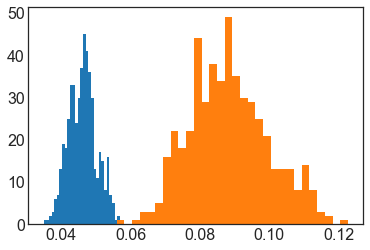

In [142]:
plt.hist(corr1k05['dA1'],bins=30)
plt.hist(corr1k05['da1'],bins=30)

(array([ 3.,  4.,  5.,  9.,  3.,  9., 10., 15., 22., 22., 30., 38., 35.,
        31., 43., 30., 33., 31., 31., 20., 19.,  8., 14., 12.,  5.,  5.,
         5.,  3.,  2.,  3.]),
 array([0.01450614, 0.01474141, 0.01497668, 0.01521195, 0.01544722,
        0.01568249, 0.01591776, 0.01615302, 0.01638829, 0.01662356,
        0.01685883, 0.0170941 , 0.01732937, 0.01756464, 0.0177999 ,
        0.01803517, 0.01827044, 0.01850571, 0.01874098, 0.01897625,
        0.01921152, 0.01944679, 0.01968205, 0.01991732, 0.02015259,
        0.02038786, 0.02062313, 0.0208584 , 0.02109367, 0.02132893,
        0.0215642 ]),
 <a list of 30 Patch objects>)

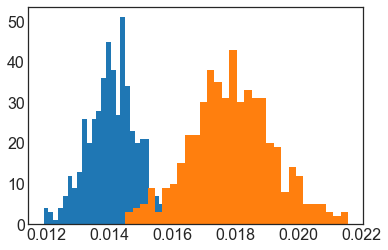

In [143]:
plt.hist(corr1k05['dA2'],bins=30)
plt.hist(corr1k05['da2'],bins=30)

In [144]:
print(corr1k05['A1'].std()/corr1k05['dA1'].mean())
print(corr1k05['A2'].std()/corr1k05['dA2'].mean())
print(corr1k05['D'].std()/corr1k05['dD'].mean())
print(corr1k05['dA1dA2'].mean()/corr1k05['da1da2'].mean())
print(corr1k05['dA1dD'].mean()/corr1k05['da1dd'].mean())
print(corr1k05['dA2dD'].mean()/corr1k05['dasdd'].mean())

1.7857396914031842
1.2938487257448577
1.263388736796846
55.646503982578785
10.704189487392409
3.2422601505730597


(array([ 2.,  6.,  5.,  6., 11., 22., 15., 23., 30., 34., 26., 42., 42.,
        34., 50., 27., 27., 28., 20., 17.,  7., 11.,  5.,  6.,  2.,  0.,
         1.,  0.,  0.,  1.]),
 array([-8.39971723e-05, -7.71001886e-05, -7.02032050e-05, -6.33062213e-05,
        -5.64092376e-05, -4.95122540e-05, -4.26152703e-05, -3.57182866e-05,
        -2.88213029e-05, -2.19243193e-05, -1.50273356e-05, -8.13035193e-06,
        -1.23336826e-06,  5.66361541e-06,  1.25605991e-05,  1.94575827e-05,
         2.63545664e-05,  3.32515501e-05,  4.01485338e-05,  4.70455174e-05,
         5.39425011e-05,  6.08394848e-05,  6.77364684e-05,  7.46334521e-05,
         8.15304358e-05,  8.84274195e-05,  9.53244031e-05,  1.02221387e-04,
         1.09118370e-04,  1.16015354e-04,  1.22912338e-04]),
 <a list of 30 Patch objects>)

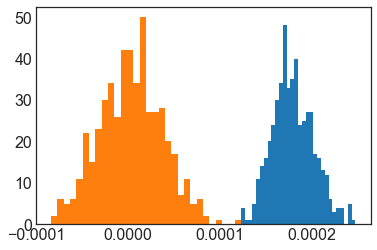

In [145]:
plt.hist(corr1k05['dA1dA2'],bins=30)
plt.hist(corr1k05['da1da2'],bins=30)

(array([ 1.,  3.,  2.,  1.,  8.,  9., 10., 18., 17., 24., 25., 43., 29.,
        33., 21., 31., 36., 37., 30., 31., 18., 10., 20.,  8., 14.,  7.,
         4.,  4.,  2.,  4.]),
 array([-1.14554256e-04, -1.00774023e-04, -8.69937895e-05, -7.32135565e-05,
        -5.94333234e-05, -4.56530904e-05, -3.18728573e-05, -1.80926243e-05,
        -4.31239126e-06,  9.46784179e-06,  2.32480748e-05,  3.70283079e-05,
         5.08085409e-05,  6.45887740e-05,  7.83690070e-05,  9.21492400e-05,
         1.05929473e-04,  1.19709706e-04,  1.33489939e-04,  1.47270172e-04,
         1.61050405e-04,  1.74830638e-04,  1.88610871e-04,  2.02391104e-04,
         2.16171337e-04,  2.29951570e-04,  2.43731804e-04,  2.57512037e-04,
         2.71292270e-04,  2.85072503e-04,  2.98852736e-04]),
 <a list of 30 Patch objects>)

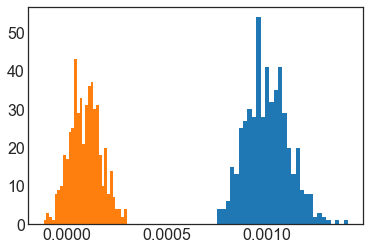

In [146]:
plt.hist(corr1k05['dA1dD'],bins=30)
plt.hist(corr1k05['da1dd'],bins=30)

(array([ 1.,  4.,  7.,  6.,  9., 14., 14., 25., 33., 42., 46., 43., 49.,
        52., 35., 33., 20., 13., 14., 14., 12.,  5.,  3.,  4.,  0.,  0.,
         0.,  1.,  0.,  1.]),
 array([2.24570230e-05, 2.61538454e-05, 2.98506679e-05, 3.35474903e-05,
        3.72443127e-05, 4.09411351e-05, 4.46379575e-05, 4.83347799e-05,
        5.20316023e-05, 5.57284247e-05, 5.94252471e-05, 6.31220695e-05,
        6.68188919e-05, 7.05157143e-05, 7.42125367e-05, 7.79093591e-05,
        8.16061815e-05, 8.53030039e-05, 8.89998263e-05, 9.26966487e-05,
        9.63934711e-05, 1.00090294e-04, 1.03787116e-04, 1.07483938e-04,
        1.11180761e-04, 1.14877583e-04, 1.18574406e-04, 1.22271228e-04,
        1.25968050e-04, 1.29664873e-04, 1.33361695e-04]),
 <a list of 30 Patch objects>)

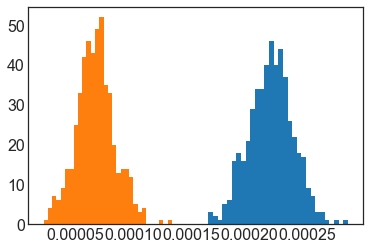

In [147]:
plt.hist(corr1k05['dA2dD'],bins=30)
plt.hist(corr1k05['dasdd'],bins=30)

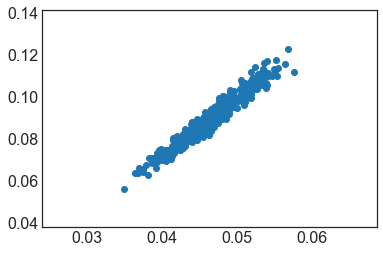

In [149]:
plt.scatter(corr1k05['dA1'],corr1k05['da1'])

Text(0, 0.5, 'dA2 ML')

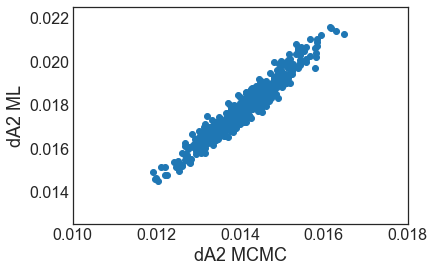

In [162]:
plt.scatter(corr1k05['dA2'],corr1k05['da2'])
plt.xlim((0.01,0.018))
plt.ylim((0.0125,0.0225))
plt.xlabel("dA2 MCMC")
plt.ylabel("dA2 ML")

In [155]:
corr1k05['dA2'].min()

0.011917932235157804